TODO: option to save everything as SVG and CSV, and add statistics for CDFs,  add n for metrics

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import seaborn as sns
from collections import namedtuple
from scipy.optimize import curve_fit
from ht2.io_handler import *

sns.set_theme("notebook", "white")

def batch_read_idealized(fpath_list):
    idl_df = []
    for i, fpath in enumerate(fpath_list):
        raw_trace = pd.read_csv(fpath, sep="\s+", index_col=False, header=None)
        raw_trace.columns = ["x", "y", "I", "t", "state"]
        idl_trace = fpath.parent.joinpath(fpath.name[:-4] + "_idealized_traces.txt")
        idl_trace = pd.read_csv(idl_trace, sep="\s+", index_col=False, header=None)
        G = idl_trace[0]
        G[G == G.max()] = 1
        G[G == G.min()] = 0
        raw_trace["Normalized Intensity"] = raw_trace["I"] - np.percentile(raw_trace["I"], 10)
        raw_trace["Normalized Intensity"] = raw_trace["Normalized Intensity"] / np.percentile(raw_trace["Normalized Intensity"], 90)
        raw_trace["Time (min)"] = raw_trace["t"] * 100 / 60
        raw_trace["State"] = idl_trace[0]
        idl_df.append(raw_trace)
    return idl_df

def read_single_cond(cond_path: Path, cond_name):
    Result = namedtuple("Result", ["name", "of_hist", "auto", "cross", "hmm", "coupled_hmm", "on_off_times"])
    gpath = cond_path.joinpath("gene")
    rpath = cond_path.joinpath("enhancer")
    cpath = cond_path.joinpath("coupled")
    spath = cond_path.joinpath("shuffled")

    if gpath.joinpath("ON_OFF_hist_CDF.dat").is_file():
        gof = pd.read_csv(gpath.joinpath("ON_OFF_hist_CDF.dat"), sep='\\s+', index_col=False, header=None)
    else:
        gof = pd.read_csv(gpath.joinpath("ON_OFF_hist.dat"), sep='\\s+', index_col=False, header=None)
    if rpath.joinpath("ON_OFF_hist_CDF.dat").is_file():
        rof = pd.read_csv(rpath.joinpath("ON_OFF_hist_CDF.dat"), sep='\\s+', index_col=False, header=None)
    else:
        rof = pd.read_csv(rpath.joinpath("ON_OFF_hist.dat"), sep='\\s+', index_col=False, header=None)

    gof.columns = ["ON", "OFF"]
    rof.columns = ["ON", "OFF"]
    

    gauto = pd.read_csv(gpath.joinpath("batch_correlation.dat"), sep='\\s+', index_col=False, header=None)
    gauto.columns=["t", "corr", "err"]
    rauto = pd.read_csv(rpath.joinpath("batch_correlation.dat"), sep='\\s+', index_col=False, header=None)
    rauto.columns=["t", "corr", "err"]
    

    rgx = pd.read_csv(cpath.joinpath("batch_correlation.dat"), sep='\\s+', index_col=False, header=None)
    rgx.columns = ["t", "corr", "err"]
    rgx = rgx.sort_values(by="t")
    # srgx = pd.read_csv(spath.joinpath("batch_correlation.dat"), sep="\s+", index_col=False, header=None)
    # srgx.columns = ["t", "corr", "err"]
    

    g_trace_list = gpath.glob("*.trk")
    g_trace_df = batch_read_idealized(g_trace_list)
    r_trace_list = rpath.glob("*.trk")
    r_trace_df = batch_read_idealized(r_trace_list)

    cg_trace_list = cpath.glob("*G_Dual*.trk")
    cg_trace_df = batch_read_idealized(cg_trace_list)
    cr_trace_list = cpath.glob("*R_Dual*.trk")
    cr_trace_df = batch_read_idealized(cr_trace_list)

    g_on =  pd.read_csv(gpath.joinpath("ON_times.dat"), index_col=False, header=None)
    g_off = pd.read_csv(gpath.joinpath("OFF_times.dat"), index_col=False, header=None)
    r_on =  pd.read_csv(rpath.joinpath("ON_times.dat"),  index_col=False, header=None)
    r_off = pd.read_csv(rpath.joinpath("OFF_times.dat"), index_col=False, header=None)

    of_hist = {"G":gof, "R":rof}
    auto_corr = {"G":gauto, "R":rauto}
    cross_corr = {"RG":rgx}
    hmm = {"G":g_trace_df, "R":r_trace_df}
    coupled_hmm = {"G":cg_trace_df, "R":cr_trace_df}
    on_off = {"G":{"ON": g_on, "OFF": g_off}, "R":{"ON": r_on, "OFF": r_off}}
    return Result(cond_name, of_hist, auto_corr, cross_corr, hmm, coupled_hmm, on_off)

def batch_read_conds(path_list, cond_names):
    result_dict = {cond_name: read_single_cond(cond_path, cond_name) for cond_path, cond_name in zip(path_list, cond_names)}
    return result_dict

from scipy import signal as sig
def smoothing(x):
    return sig.convolve(x, np.array([1/3, 1/3, 1/3]), mode="same", method="auto")


def plot_of_hist(data, cond_names, out_path=None):
    dt = 100/60
    ch_map = {"G":"Gene", "R":"Enhancer"}
    fig, axes = plt.subplots(2, 2, figsize=(8, 7))
    for i, ch in enumerate(["G", "R"]):
        for j, state in enumerate(["ON", "OFF"]):
            for k, cond in enumerate(cond_names):
                axes[i, j].plot(
                    np.arange(len(data[cond].of_hist[ch])) * dt, 
                    data[cond].of_hist[ch][state] / data[cond].of_hist[ch][state].max(), 
                    label=cond)
                axes[i, j].set_title("{} {}-Time CDF".format(ch_map[ch], state))
                axes[i, j].set_xlim([0, 1080])
    fig.legend(cond_names, loc="lower right")
    fig.supxlabel("Time (min)", y=0.03)
    fig.supylabel("Cumulative Probability")
    plt.tight_layout(rect=[0, 0, 1, 1.2])
    if out_path is not None:
        plt.savefig(Path(out_path).joinpath("{}_ON_OFF_hist.svg".format("-".join(cond_names))), format="svg")
    plt.show()

def plot_auto_correlations(data, cond_names, out_path = None):
    dt = 100/60
    ch_map = {"G":"Gene", "R":"Enhancer"}
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    for i, ch in enumerate(["G", "R"]):
        for k, cond in enumerate(cond_names):
            max_val = data[cond].auto[ch]["corr"].max()
            axes[i].plot(
                data[cond].auto[ch]["t"] / 60, 
                data[cond].auto[ch]["corr"] / max_val, 
                label=cond)
            axes[i].fill_between(
                data[cond].auto[ch]["t"] / 60, 
                (data[cond].auto[ch]["corr"] + data[cond].auto[ch]["err"]) / max_val, 
                (data[cond].auto[ch]["corr"] - data[cond].auto[ch]["err"]) / max_val, 
                alpha=0.3)
        axes[i].set_title("{} Autocorrelation".format(ch_map[ch]))
        axes[i].set_xlim([0, 200])
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right")
    fig.supxlabel("Time Lag (min)")
    fig.supylabel("Correlation")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if out_path is not None:
        plt.savefig(Path(out_path).joinpath("{}_autocorrelation.svg".format("-".join(cond_names))), format="svg")
    plt.show()

def plot_cross_correlations(data, cond_names, out_path = None):
    dt = 100/60
    fig, axes = plt.subplots(1, 1, figsize=(6, 4))
    lines, labels = [], []
    for k, cond in enumerate(cond_names):
        axes.plot(
            data[cond].cross["RG"]["t"] / 60, 
            data[cond].cross["RG"]["corr"], 
            label=cond)
        axes.fill_between(
            data[cond].cross["RG"]["t"] / 60, 
            (data[cond].cross["RG"]["corr"] + data[cond].cross["RG"]["err"]), 
            (data[cond].cross["RG"]["corr"] - data[cond].cross["RG"]["err"]), 
            alpha=0.3)
    axes.set_title("Enhancer-Gene Cross Correlation")
    handles, labels = axes.get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right", ncol=2, frameon=False)
    fig.supxlabel("Time Lag (min)", y=0.03)
    fig.supylabel("Correlation")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.xlim([-200, 200])
    plt.ylim([-0.3, 0.3])
    if out_path is not None:
        plt.savefig(Path(out_path).joinpath("{}_crosscorrelation.svg".format("-".join(cond_names))), format="svg")
    plt.show()

def plot_burst_fraction(data, cond_names, g_fracs=None, r_fracs=None, out_path = None):
    dt = 100/60
    ch_map = {"G":"Gene", "R":"Enhancer"}
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    for i, ch in enumerate(["G", "R"]):
        for k, cond in enumerate(cond_names):
            x = pd.concat(data[cond].hmm[ch]).groupby("t")["State"].mean()
            t = np.arange(len(x))
            axes[i].plot(t[:400] * dt, x[:400])
        axes[i].set_title("{} Bursting Fraction Over Time".format(ch_map[ch]))
        axes[i].set_ylim([-0.05, 1.05])
    fig.supxlabel("Time (min)")
    fig.supylabel("Bursting Fraction")
    
    plt.legend(cond_names)
    if out_path is not None:
        plt.savefig(Path(out_path).joinpath("{}_burst_fraction.svg".format("-".join(cond_names))), format="svg")
    plt.show()

def exp_decay(t, lambd, C):
    "lambd for exponential factor, a for scaling, b for offset"
    return np.exp(-lambd * t) + C

def fit_exp(y, t, lambd0=10):
    popt, pcov = curve_fit(exp_decay, t, y, p0=[lambd0, 0], bounds=([0.0000001, -1], [np.inf, 1]), method='trf')
    return popt

def get_metrics(data, out_path = None):
    dt = 100/60
    ch_map = {"G":"Gene", "R":"Enhancer"}
    df = {}
    for key, result in data.items():
        # fit exponential and get single decay rate
        # average on time
        # average off time
        data_vec = {}
        for ch in ["G", "R"]:
            max_val = result.auto[ch]["corr"].max()
            t = result.auto[ch]["t"] / 60
            y = result.auto[ch]["corr"] / max_val
            lambd = fit_exp(y, t)
            data_vec["{} Autocorrelation Decay Rate (1/min)".format(ch_map[ch])] = lambd[0]
            data_vec["{} Tau 1/2 (min)".format(ch_map[ch])] = np.log(2) / lambd[0]
        for ch in ["G", "R"]:
            for state in ["ON", "OFF"]:
                data_vec["Mean {} {} Time (min)".format(ch_map[ch], state)] = result.on_off_times[ch][state].mean().iloc[0] * 100 / 60
        df[key] = data_vec
    df = pd.DataFrame.from_dict(df, orient="index")
    if out_path is not None:
        df.to_csv(Path(out_path).joinpath("metrics.csv"))
    return df

def collect_all_tables(data:dict, out_path):
    check_dir(Path(out_path), create_if_not=True)
    dt = 100/60
    ch_map = {"G":"Gene", "R":"Enhancer"}
    cond_names = data.keys()
    for i, ch in enumerate(["G", "R"]):
        for j, state in enumerate(["ON", "OFF"]):
            of_hist_df = {}
            for k, cond in enumerate(cond_names):
                of_hist_df[cond] = data[cond].of_hist[ch][state] / data[cond].of_hist[ch][state].max()
            pd.DataFrame.from_dict(of_hist_df).to_csv(Path(out_path).joinpath("{}_{}_hist.csv".format(ch_map[ch], state)))

        auto_corr_df_norm = {}
        auto_corr_df = {}
        for k, cond in enumerate(cond_names):
            max_val = data[cond].auto[ch]["corr"].max()
            auto_corr_df_norm["{}.t".format(cond)] = data[cond].auto[ch]["t"] / 60
            auto_corr_df_norm["{}.corr".format(cond)] = data[cond].auto[ch]["corr"] / max_val
            auto_corr_df_norm["{}.err".format(cond)] = data[cond].auto[ch]["err"] / max_val
            auto_corr_df["{}.t".format(cond)] = data[cond].auto[ch]["t"] / 60
            auto_corr_df["{}.corr".format(cond)] = data[cond].auto[ch]["corr"]
            auto_corr_df["{}.err".format(cond)] =  data[cond].auto[ch]["err"]
        pd.DataFrame.from_dict(auto_corr_df).to_csv(Path(out_path).joinpath("{}_autocorrelation.csv".format(ch_map[ch])))
        pd.DataFrame.from_dict(auto_corr_df_norm).to_csv(Path(out_path).joinpath("{}_autocorrelation_normalized.csv".format(ch_map[ch])))

        burst_frac_df = {}
        for k, cond in enumerate(cond_names):
            burst_frac_df[cond] = pd.concat(data[cond].hmm[ch]).groupby("t")["State"].mean()
        pd.DataFrame.from_dict(burst_frac_df).to_csv(Path(out_path).joinpath("{}_burstfraction.csv".format(ch_map[ch])))

    xcorr_df = {}
    for k, cond in enumerate(cond_names):
        xcorr_df["{}.t"] = data[cond].cross["RG"]["t"] / 60 
        xcorr_df["{}.corr"] = data[cond].cross["RG"]["corr"]
        xcorr_df["{}.err"] = data[cond].cross["RG"]["err"]
    pd.DataFrame.from_dict(xcorr_df).to_csv(Path(out_path).joinpath("{}_crosscorrelation.csv".format(ch_map[ch])))
def batch_compare(data, comparisons, out_path=None):
    for cond_names in comparisons:
        print(cond_names)
        plot_of_hist(data, cond_names, out_path)
        plot_auto_correlations(data, cond_names, out_path)
        plot_cross_correlations(data, cond_names, out_path)
        plot_burst_fraction(data, cond_names, out_path)
        print("#############################################################")

In [44]:
# Replace with path with track folders for multiple conditions and replace with their respective condition names
parent_path = Path(r"C:\Users\Imageanalysis\Desktop\Ike\New")
path_list = sorted(parent_path.glob("*"))
cond_names = ["Fibronectin", 
              "Laminin", 
              "Soft FN", 
              "Soft Lam", 
              "Stiff FN", 
              "Stiff Lam", 
              "20% Stretch", 
              "0% Stretch", 
              "Control", 
              "Hypotonic", 
              "Compression"]
[print(dirpath.name, " || ", cond) for dirpath, cond in zip(path_list, cond_names)]

001-1MaxIP_fn  ||  Fibronectin
001-1MaxIP_lam  ||  Laminin
003-4_soft_fn  ||  Soft FN
003-4_soft_lam  ||  Soft Lam
003-4_stiff_fn  ||  Stiff FN
003-4_stiff_lam  ||  Stiff Lam
004-4MaxIP_STRETCH_20  ||  20% Stretch
005-1MaxIP_STRETCH_0  ||  0% Stretch
009-0Cont  ||  Control
47_49HypOtonic_hyp_ctrl  ||  Hypotonic
56Compression  ||  Compression


[None, None, None, None, None, None, None, None, None, None, None]

In [45]:
data = batch_read_conds(path_list, cond_names) # run to read all conditions at once
out_path = "figure_dump"

In [52]:
df = get_metrics(data)
collect_all_tables(data, out_path=out_path)

dict_keys(['Fibronectin', 'Laminin', 'Soft FN', 'Soft Lam', 'Stiff FN', 'Stiff Lam', '20% Stretch', '0% Stretch', 'Control', 'Hypotonic', 'Compression'])


['Control', 'Fibronectin']


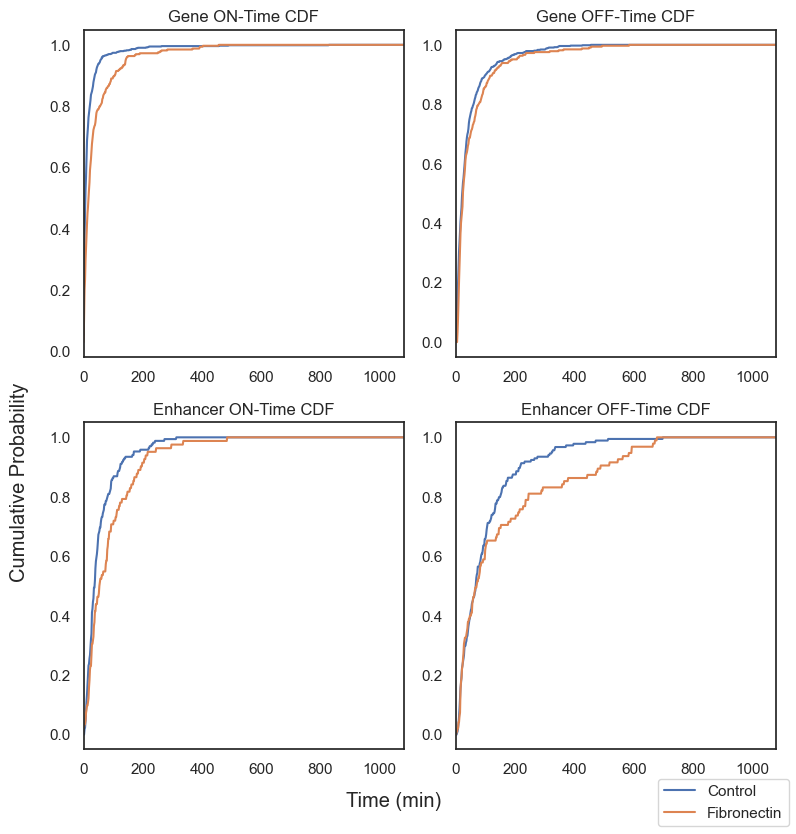

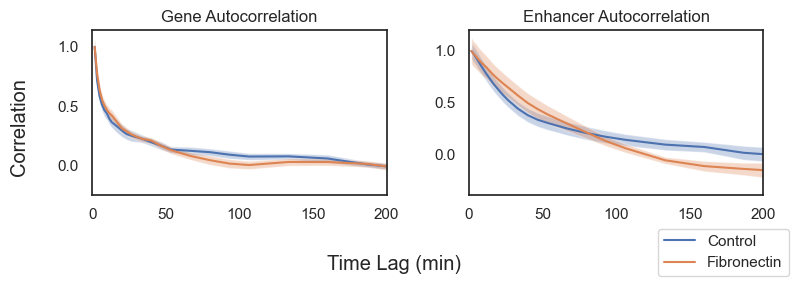

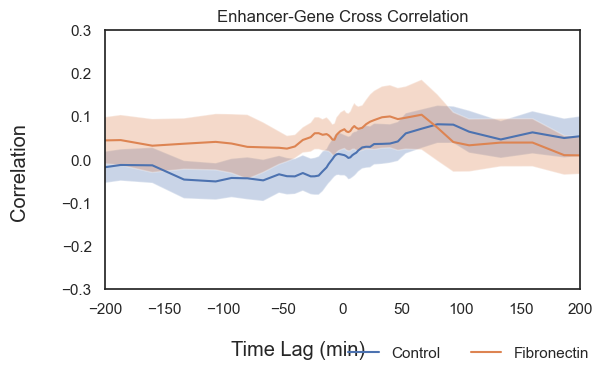

C:\Users\Imageanalysis\AppData\Local\Temp\ipykernel_277076\2977625031.py:176: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  axes[i].plot(t[:400] * dt, x[:400])


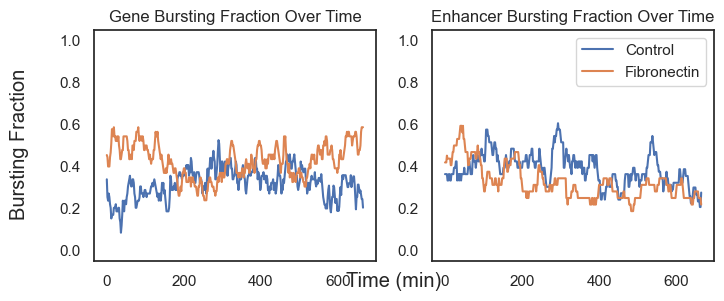

#############################################################
['Control', 'Laminin']


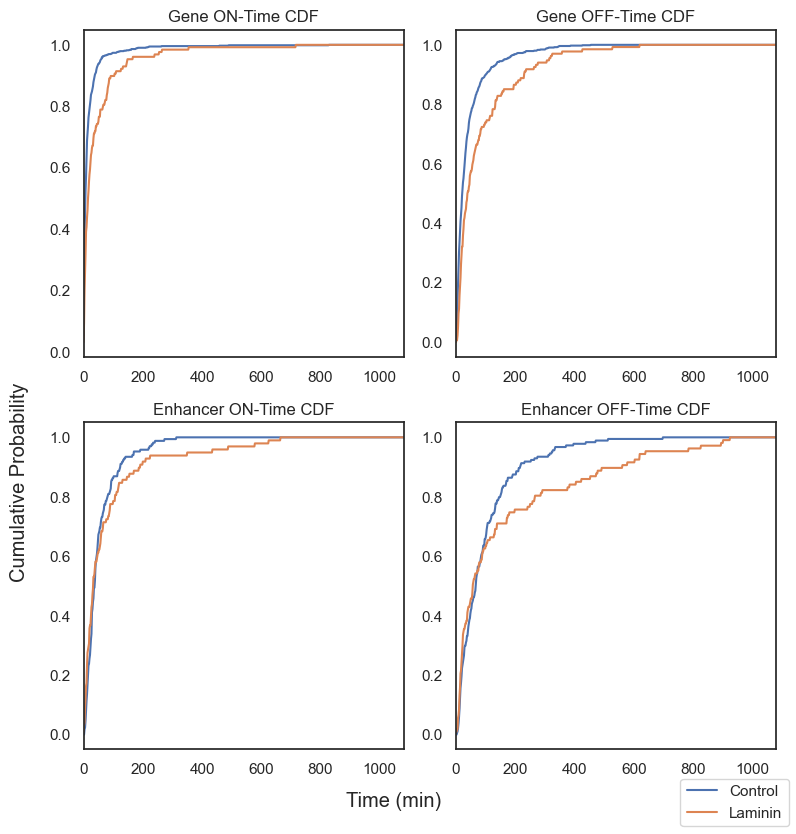

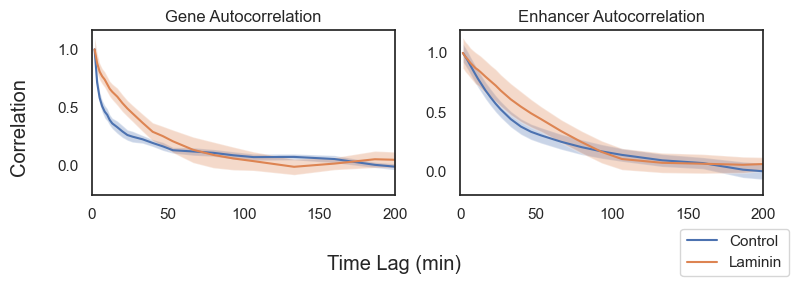

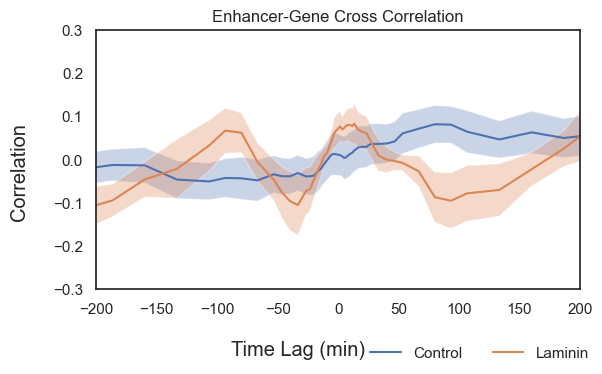

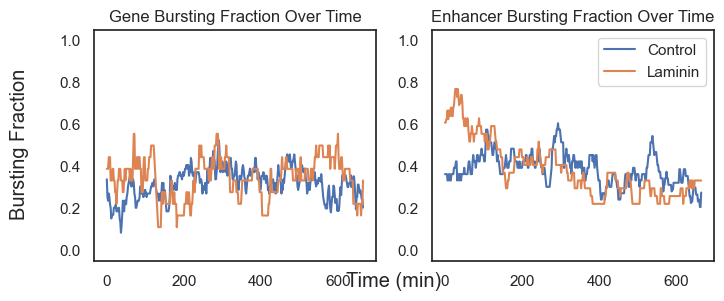

#############################################################
['Control', 'Hypotonic']


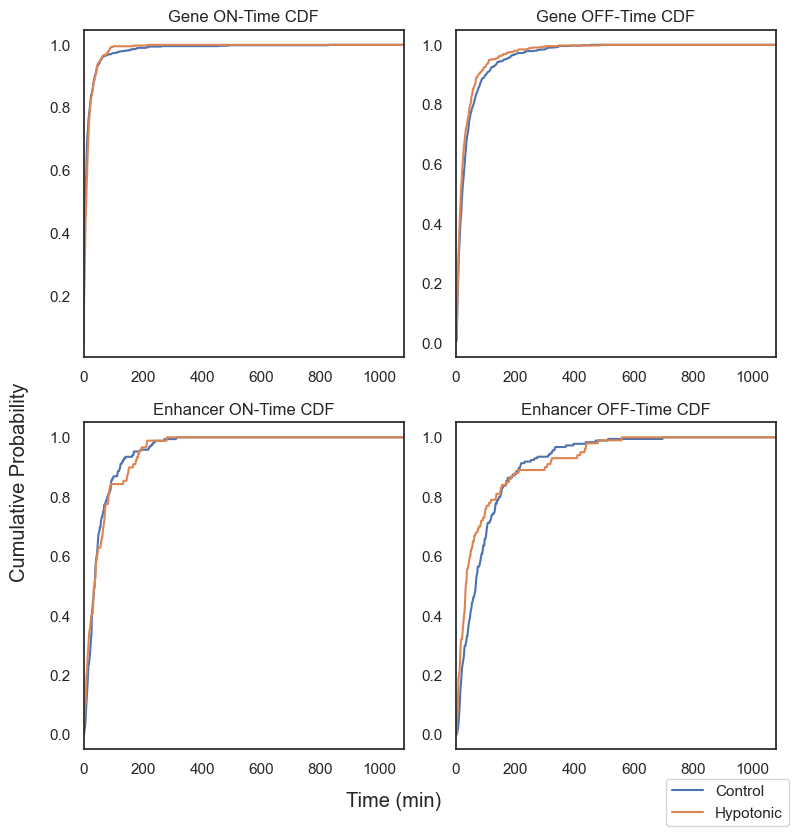

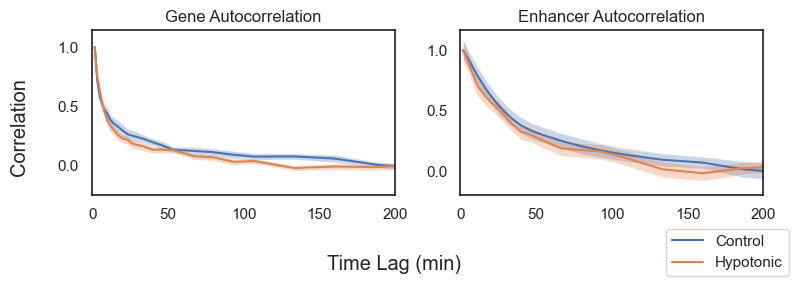

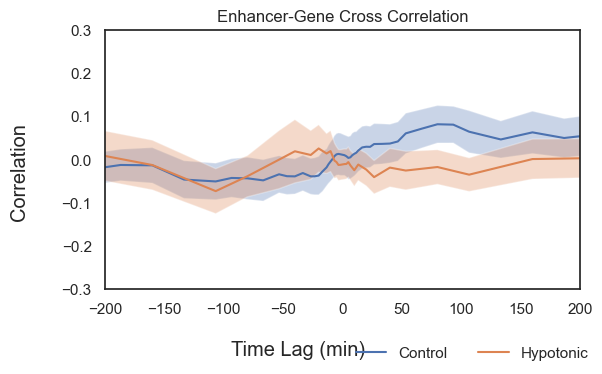

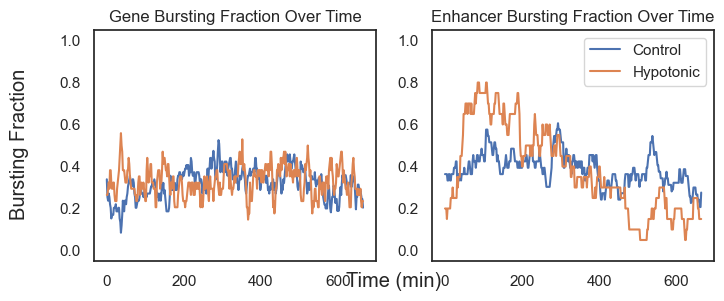

#############################################################
['Control', 'Compression']


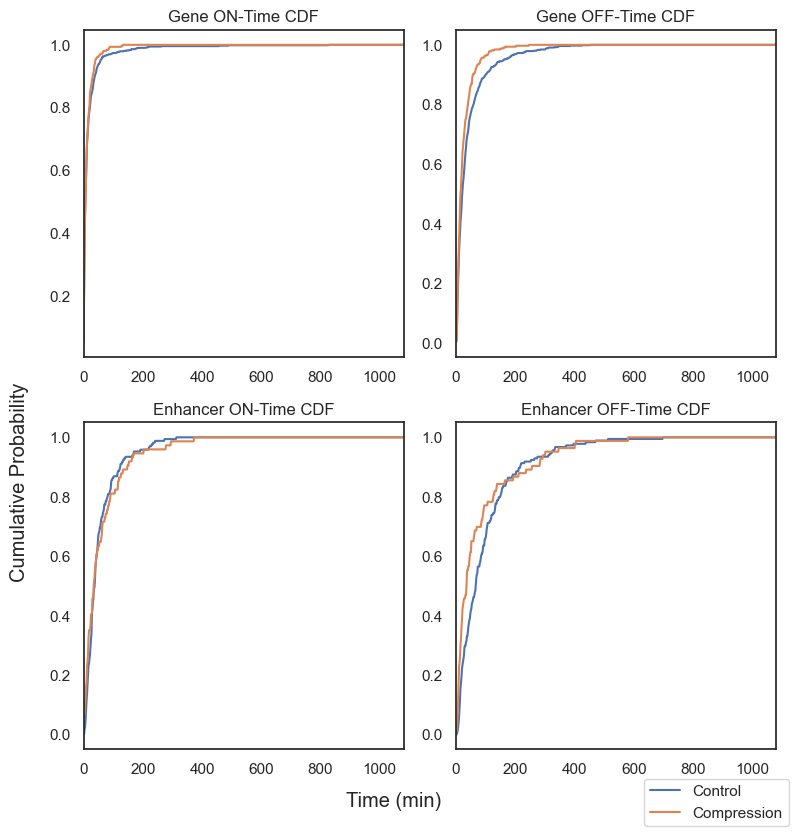

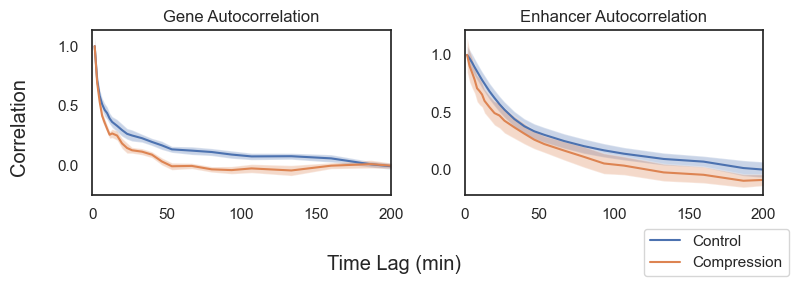

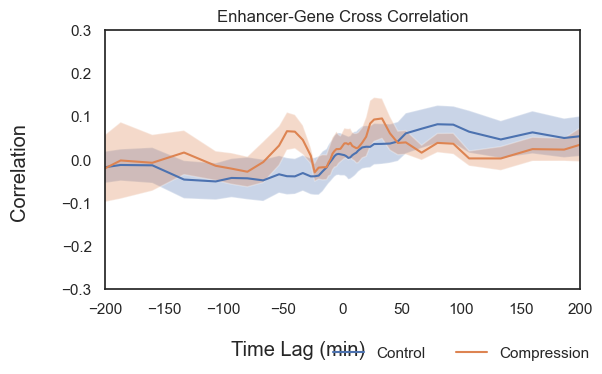

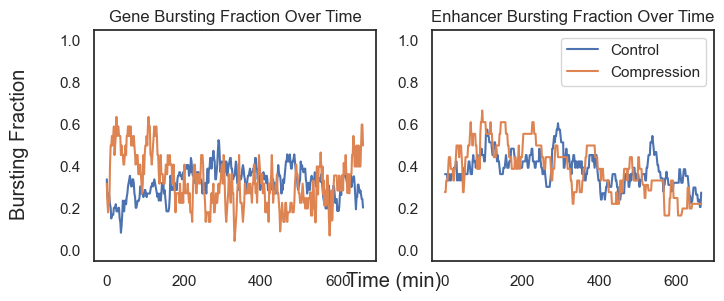

#############################################################
['Control', 'Stiff FN']


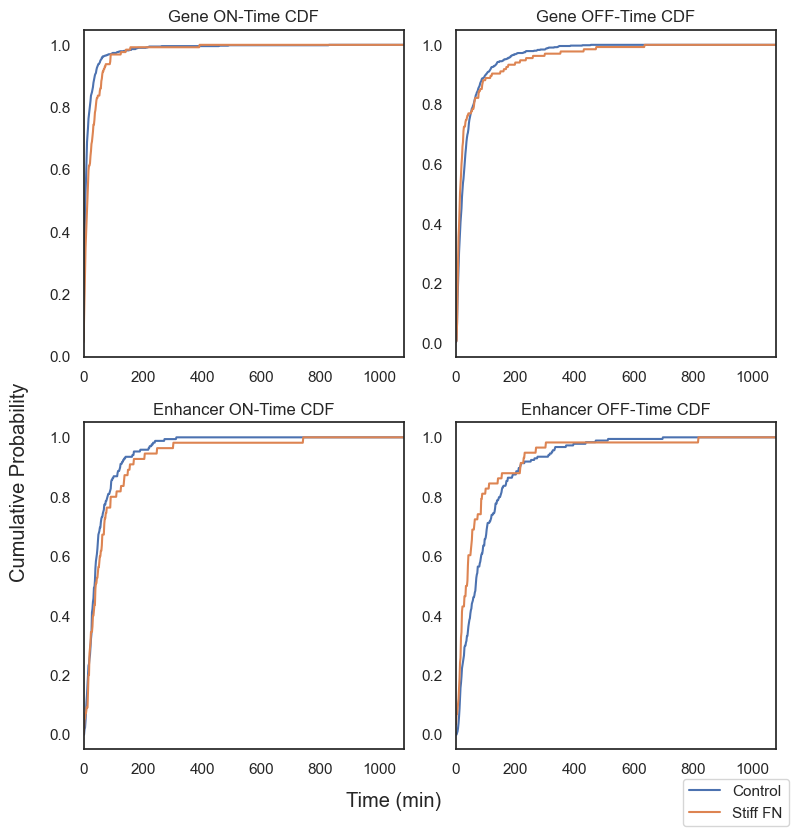

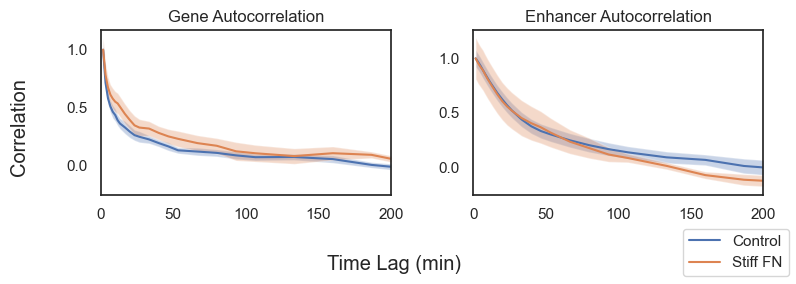

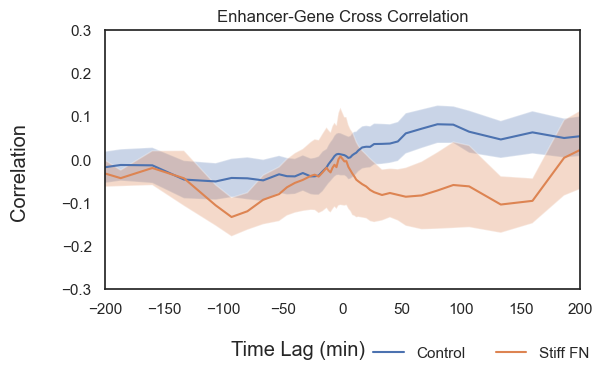

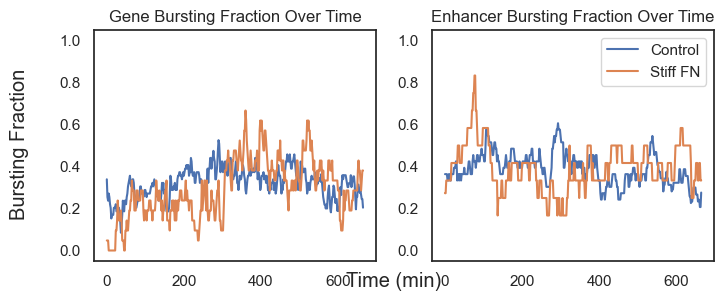

#############################################################
['Control', 'Stiff Lam']


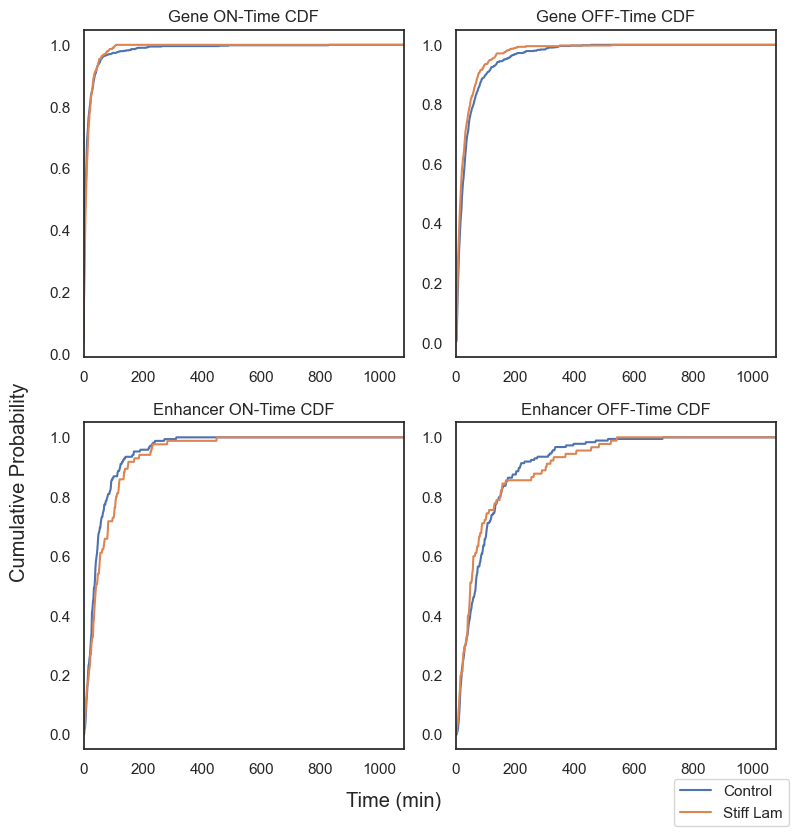

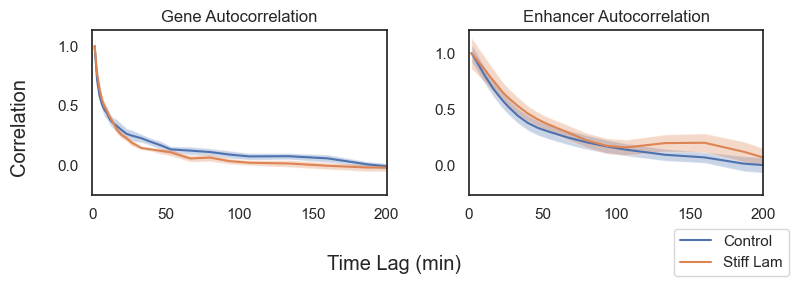

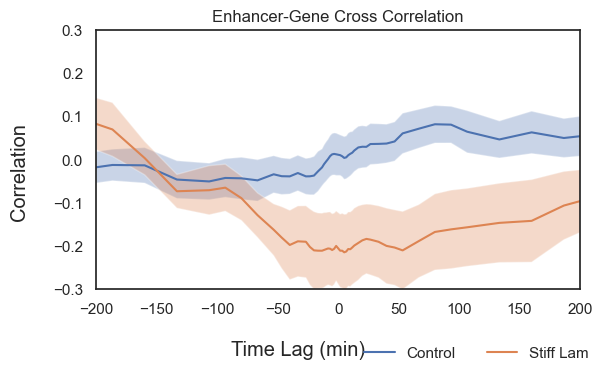

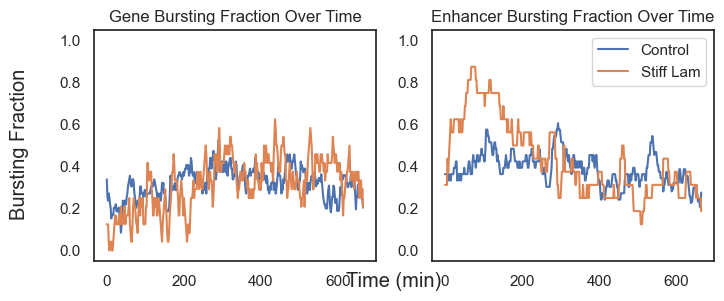

#############################################################
['Control', 'Soft FN']


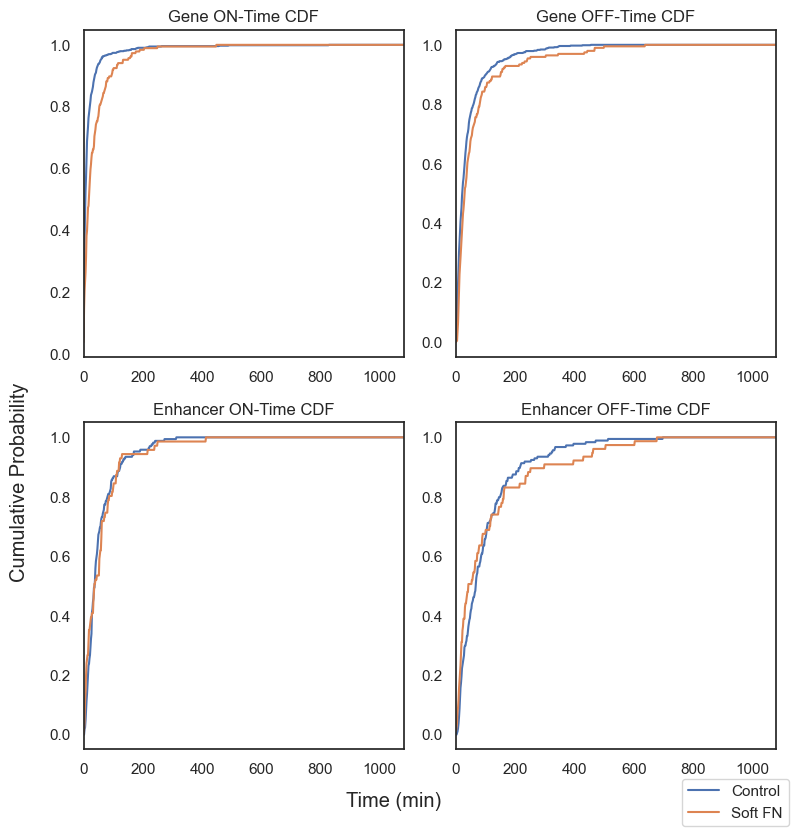

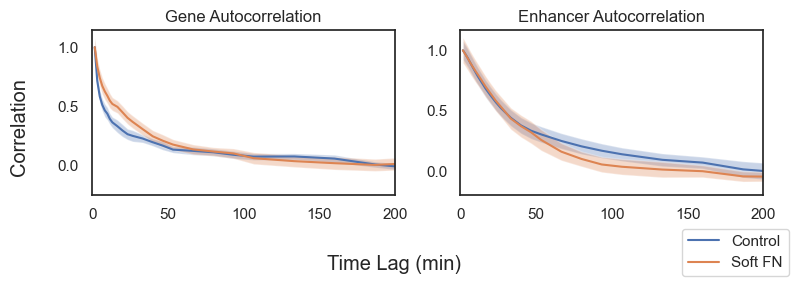

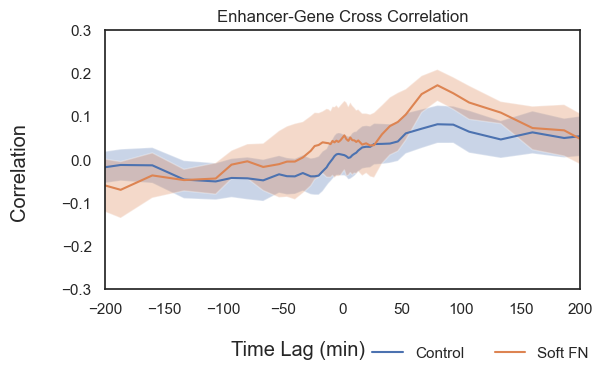

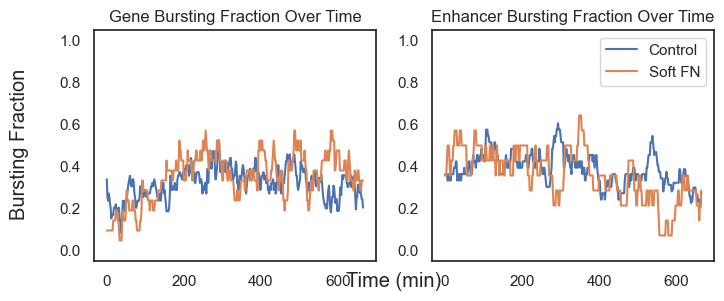

#############################################################
['Control', 'Soft Lam']


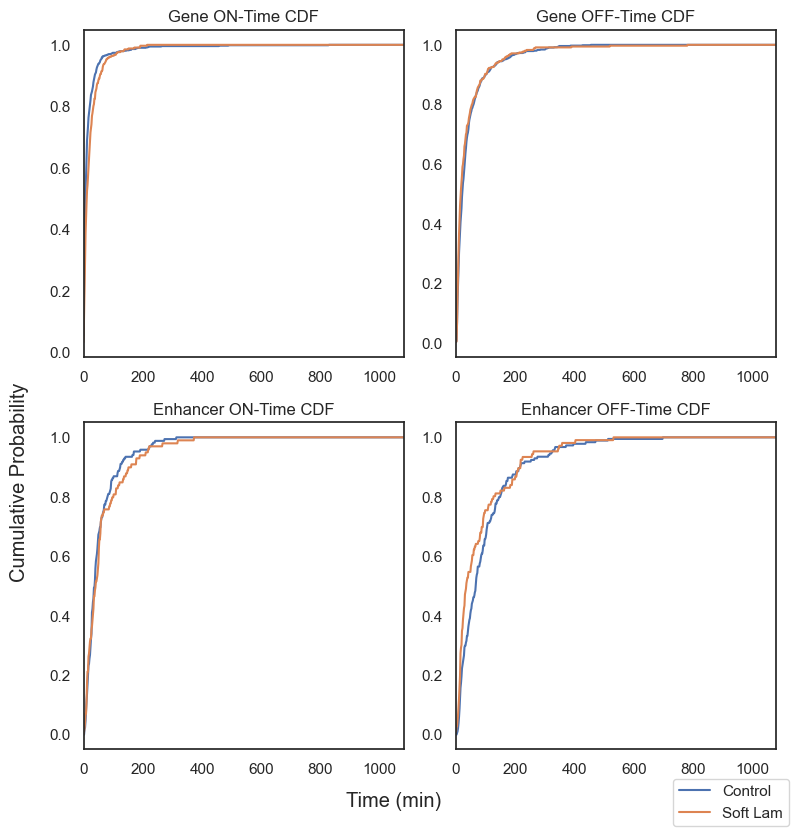

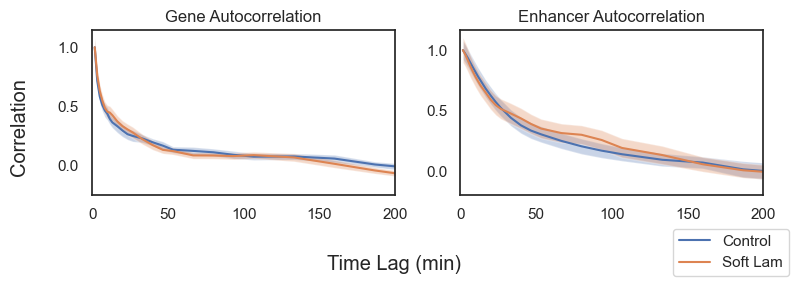

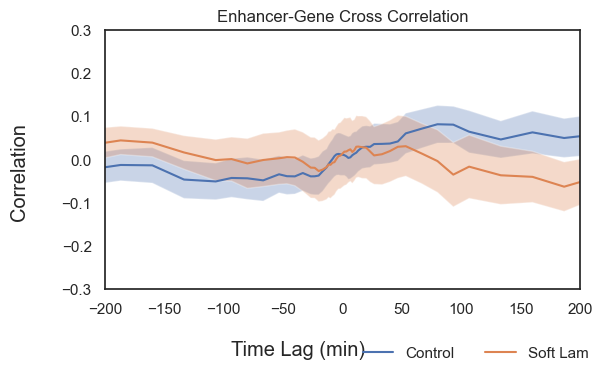

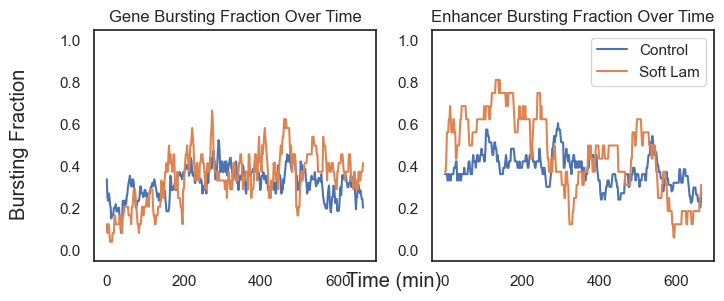

#############################################################
['0% Stretch', '20% Stretch']


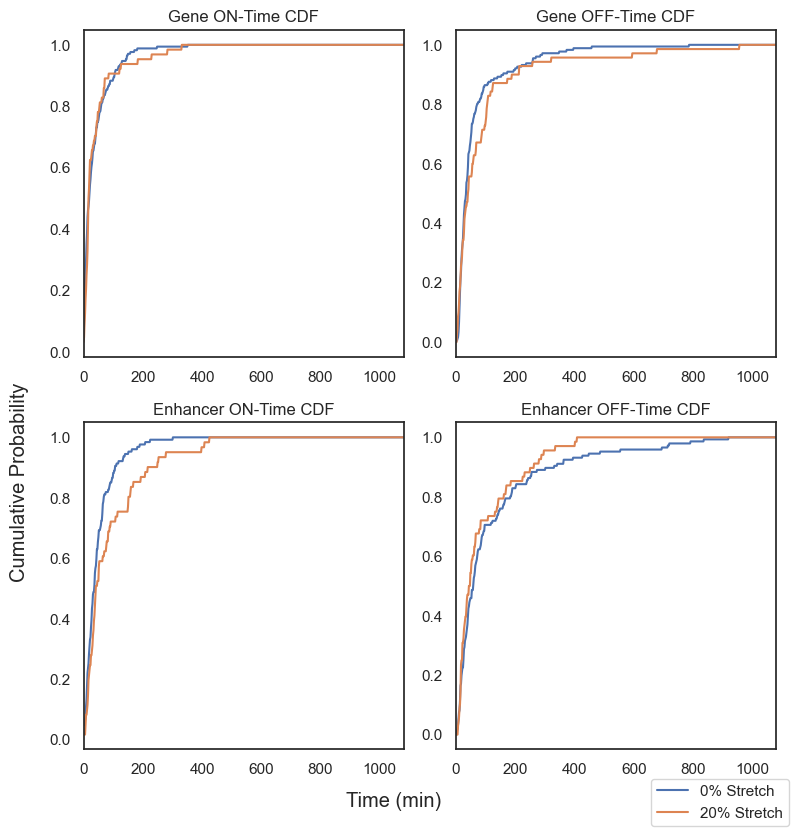

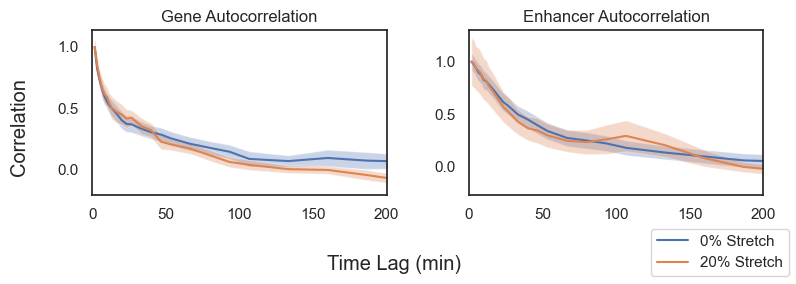

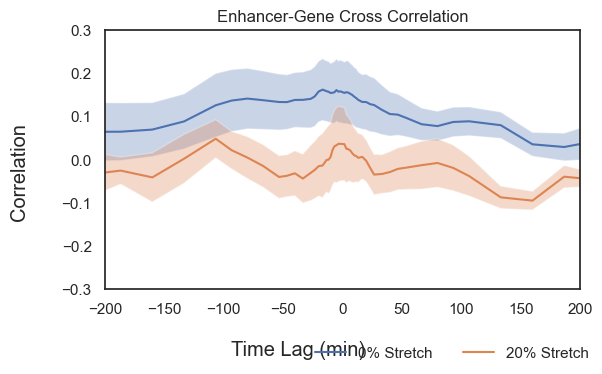

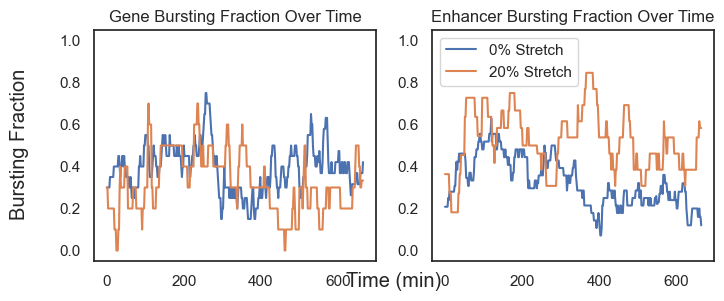

#############################################################
['Soft FN', 'Soft Lam']


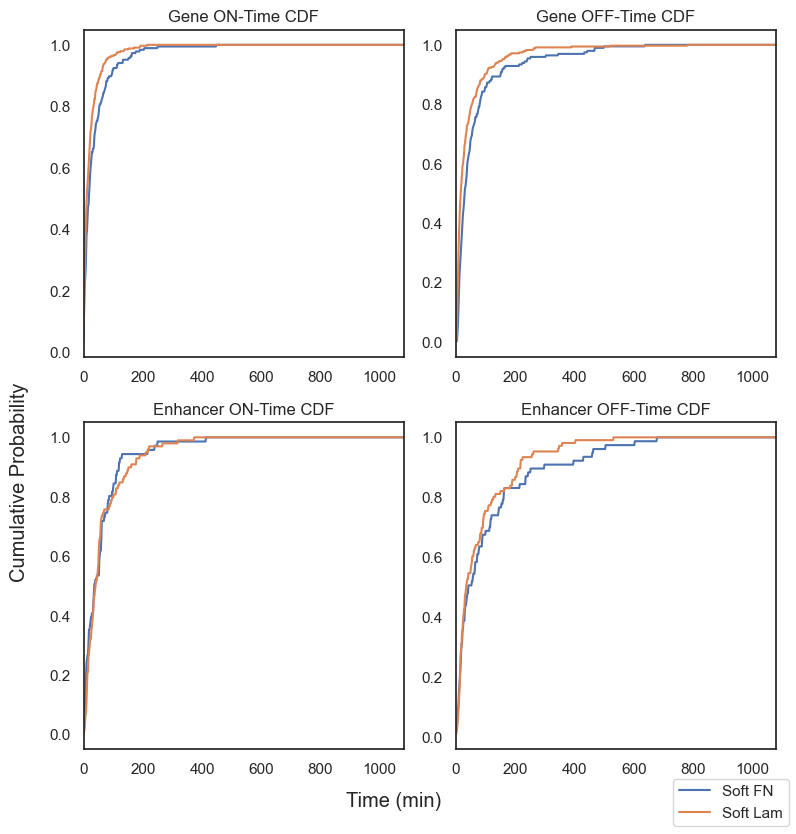

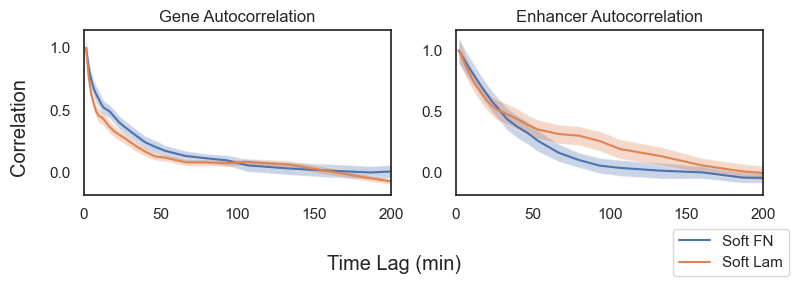

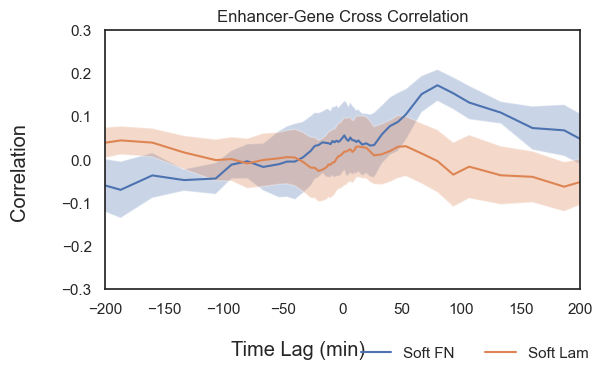

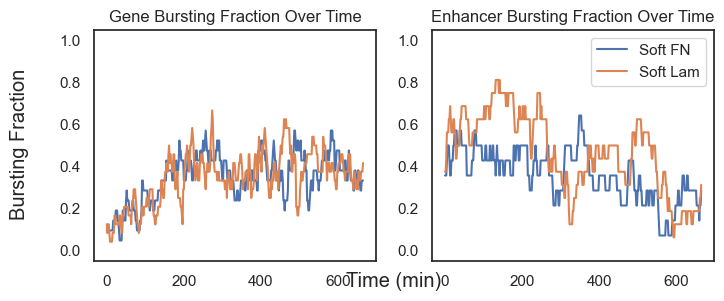

#############################################################
['Stiff FN', 'Stiff Lam']


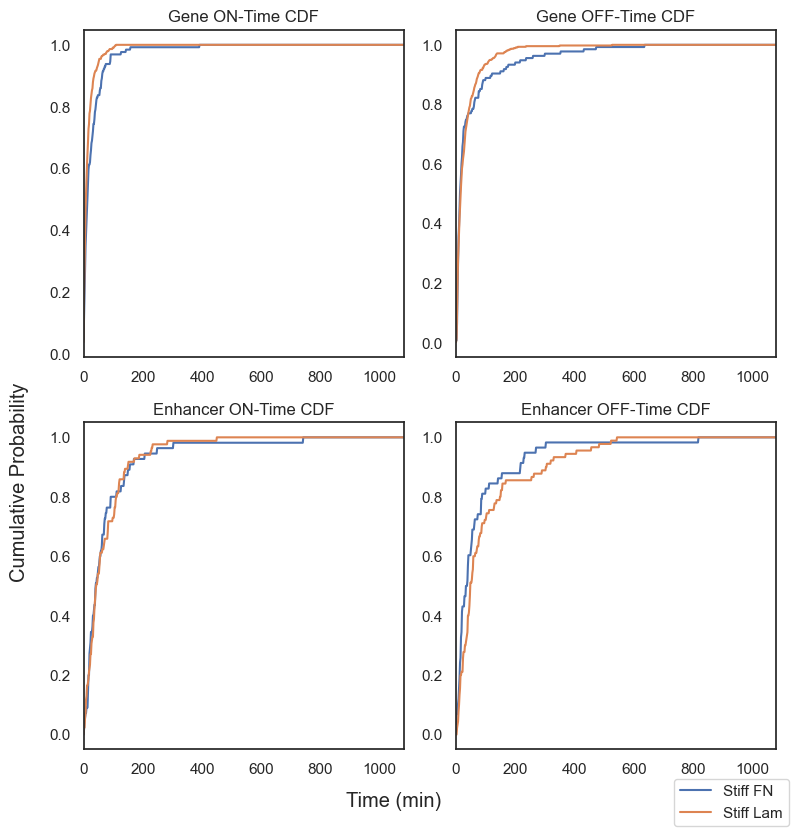

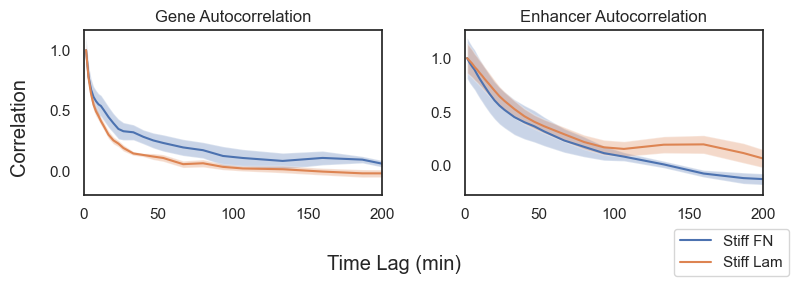

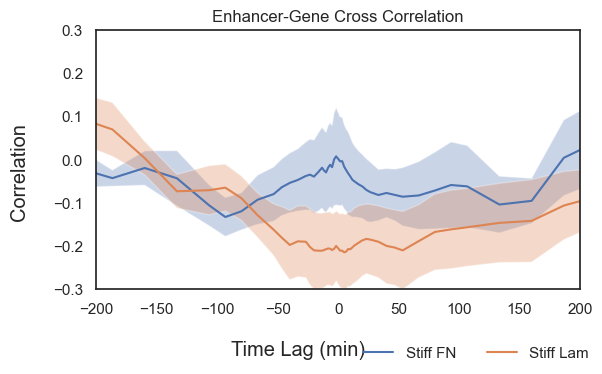

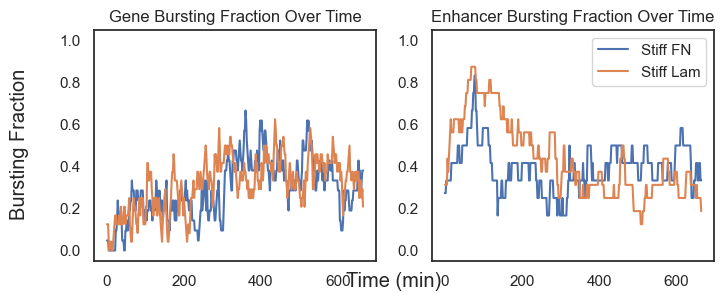

#############################################################
['Stiff FN', 'Soft FN']


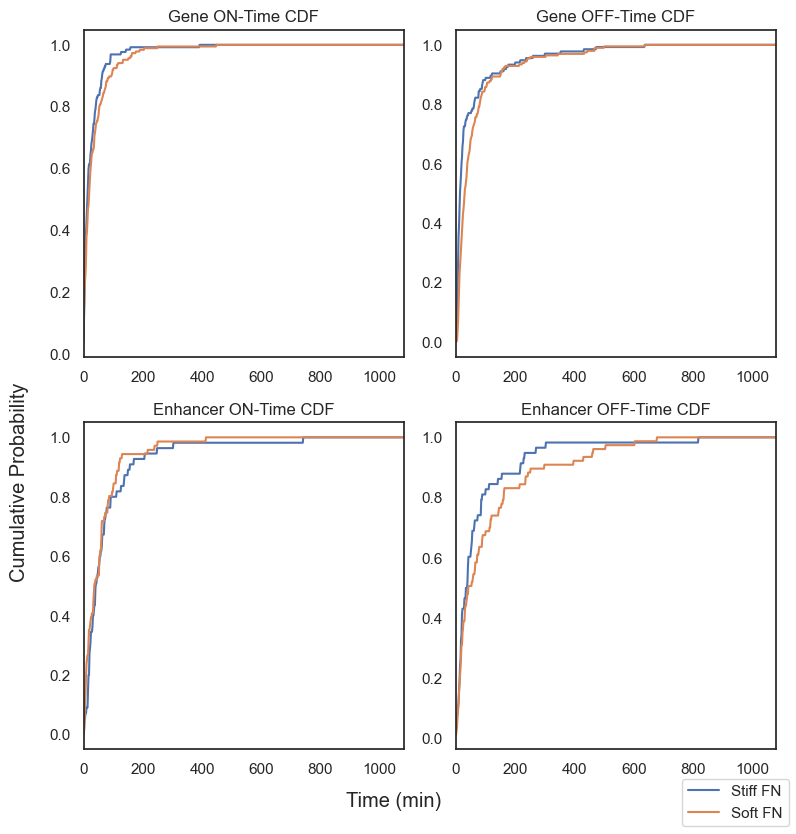

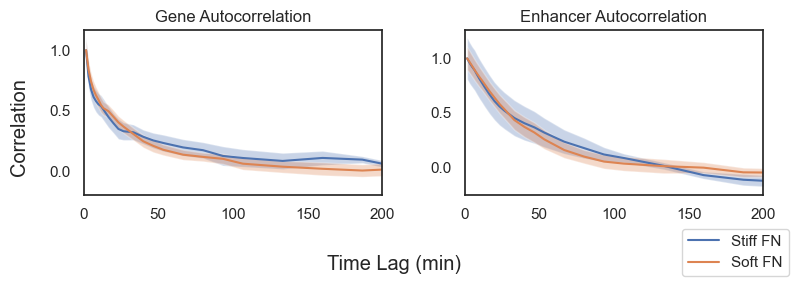

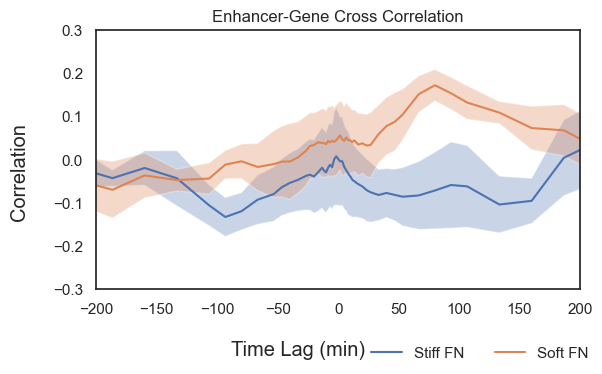

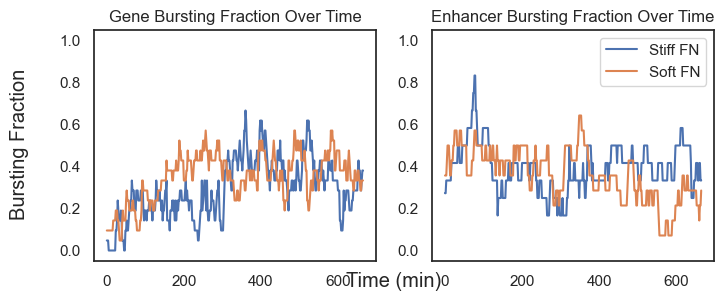

#############################################################
['Stiff Lam', 'Soft Lam']


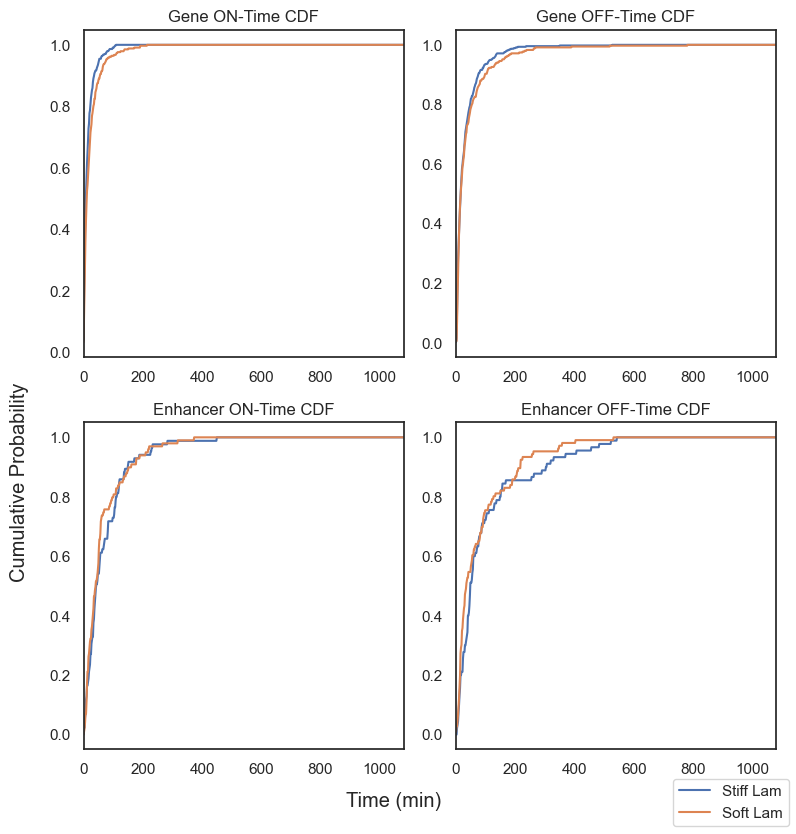

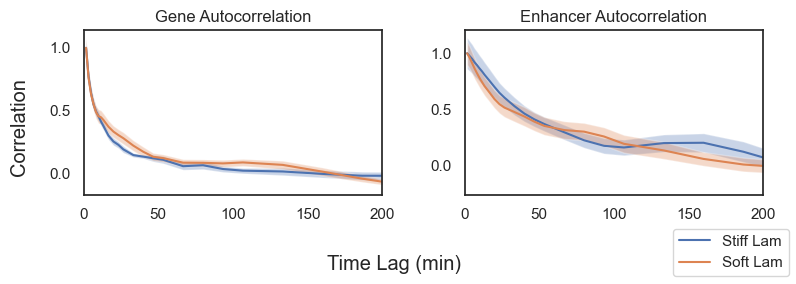

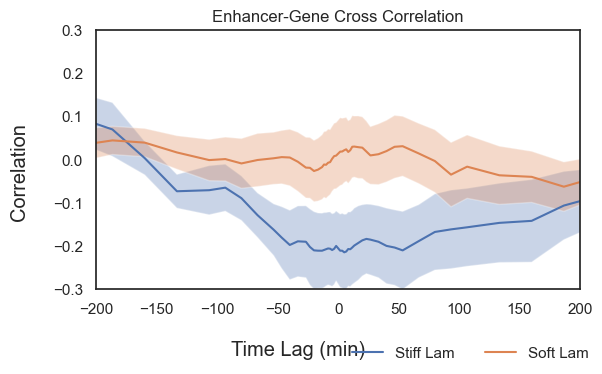

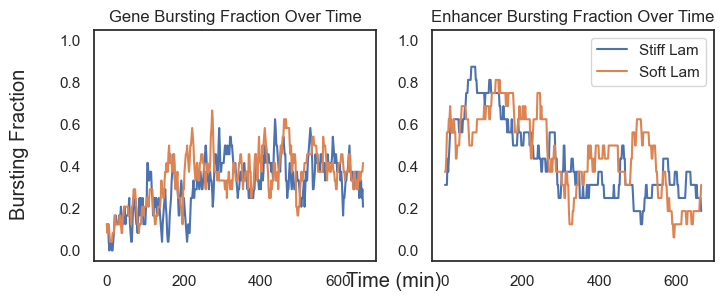

#############################################################
['Control', 'Fibronectin', 'Laminin']


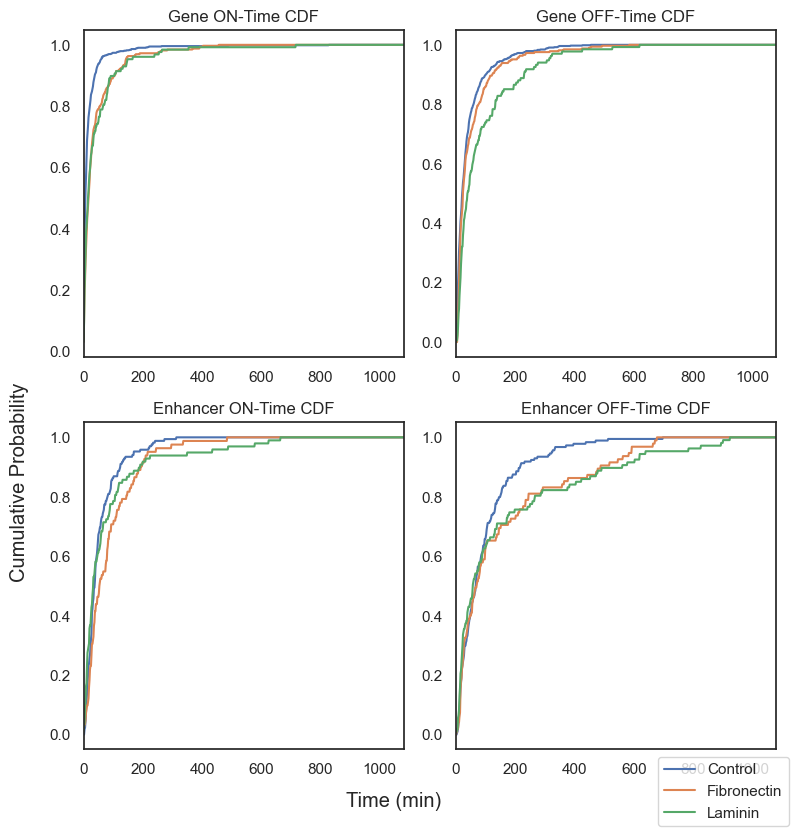

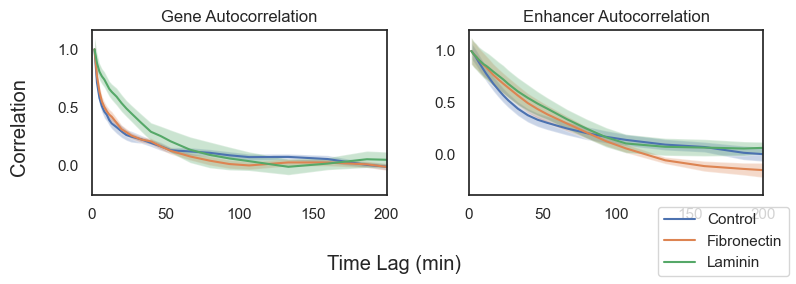

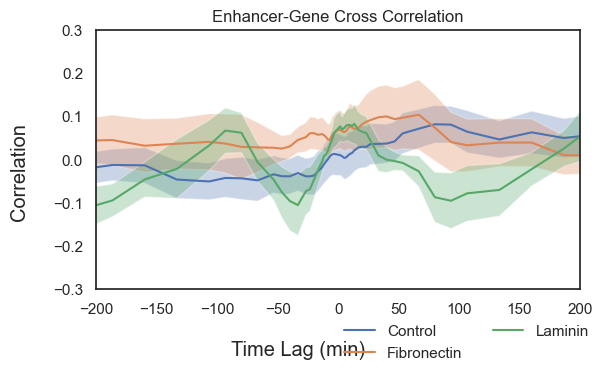

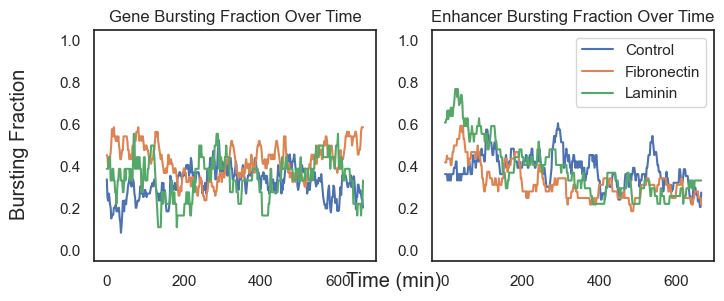

#############################################################


In [56]:
batch_compare(data, [

    ["Control", "Fibronectin"],
    ["Control", "Laminin"],
    ["Control", "Hypotonic"],
    ["Control", "Compression"],
    ["Control", "Stiff FN"],
    ["Control", "Stiff Lam"],
    ["Control", "Soft FN"],
    ["Control", "Soft Lam"],
    ["0% Stretch", "20% Stretch"],

    ["Soft FN", "Soft Lam"],
    ["Stiff FN", "Stiff Lam"],
    ["Stiff FN", "Soft FN"],
    ["Stiff Lam", "Soft Lam"],
    ["Control","Fibronectin", "Laminin"],

], out_path=out_path)